In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from mplfinance.original_flavor import candlestick_ohlc 
import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_price_data():
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-9-30')
    return tickerDf.iloc[:, :5]

In [3]:
ticker='AMZN'
df1 = get_price_data()
df1

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,68922000
...,...,...,...,...,...
2022-09-23,116.000000,116.050003,112.059998,113.779999,65081200
2022-09-26,113.300003,117.339996,113.129997,115.150002,62723300
2022-09-27,117.199997,118.320000,113.050003,114.410004,60094700


In [5]:
ticker='WMT'
df2 = get_price_data()
df2

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,61.829523,61.829523,60.766889,61.311604,10473200
2017-01-04,61.311590,62.177768,61.258006,61.668774,7918000
2017-01-05,61.106216,61.909894,60.829396,61.802734,7099200
2017-01-06,61.088358,61.168722,60.731167,60.954411,9491100
2017-01-09,61.016915,61.436614,61.007984,61.356243,8685200
...,...,...,...,...,...
2022-09-23,132.869995,133.179993,128.770004,130.059998,9062300
2022-09-26,128.750000,132.139999,128.270004,131.309998,7670400
2022-09-27,132.229996,133.429993,130.300003,130.949997,5723900


In [6]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

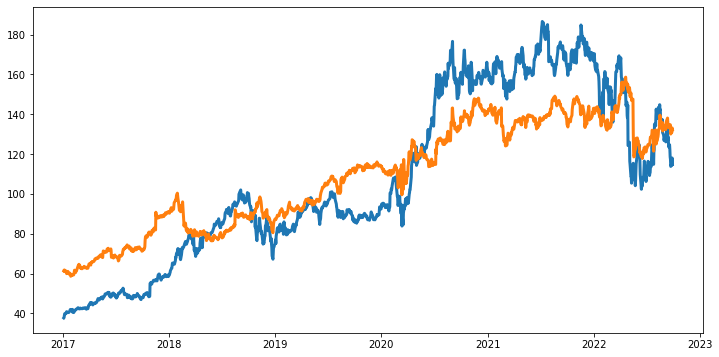

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Close'], linewidth=3.0)
plt.plot(df2['Close'], linewidth=3.0)

plt.show()

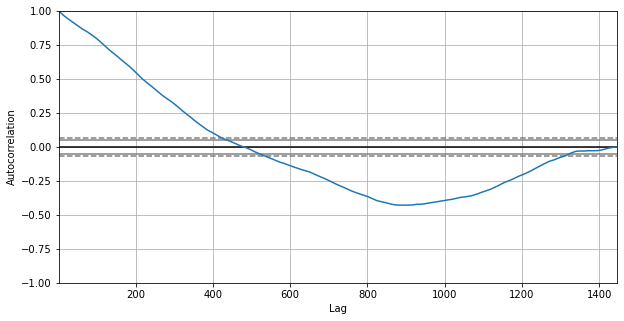

In [8]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10, 5))

autocorrelation_plot(df1['Close'])
plt.show()

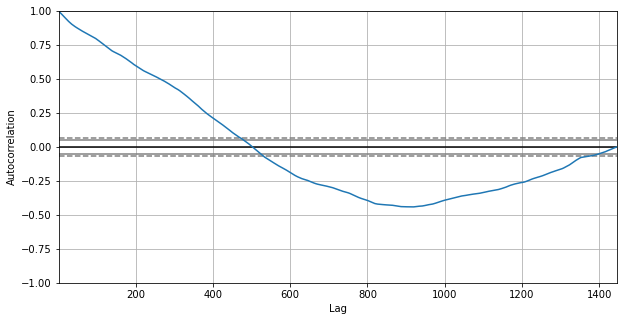

In [9]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10, 5))

autocorrelation_plot(df2['Close'])
plt.show()

In [11]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [13]:
series = df1['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.713936
p-value                           0.423947
#Lags Used                        0.000000
Number of Observations Used    1445.000000
Critical Value (1%)              -3.434884
Critical Value (5%)              -2.863542
Critical Value (10%)             -2.567836
dtype: float64


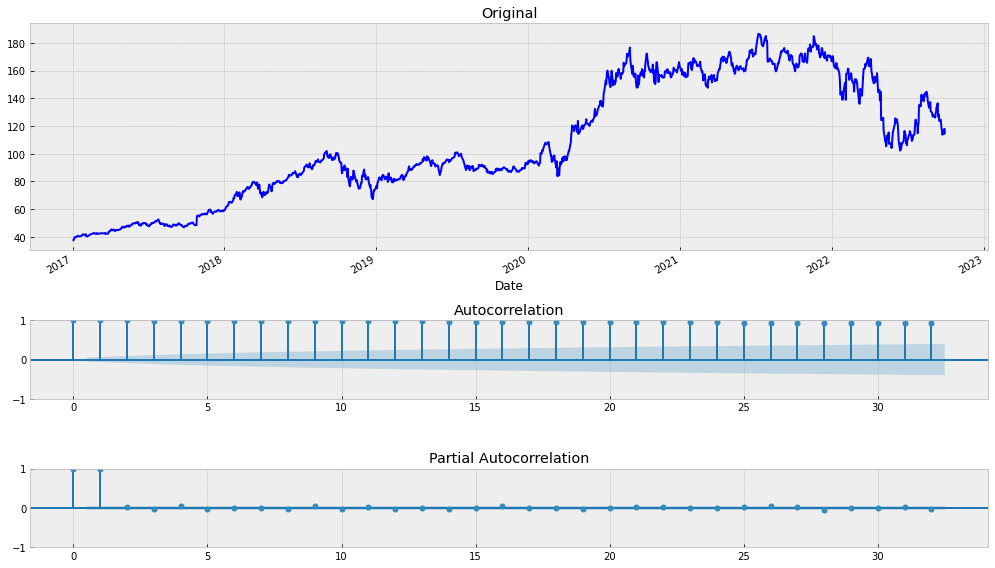

In [14]:
tsplot(series)

p-value = 0.240154 
Р>0.05, значит нельзя отвергнуть нулевую гипотезу. Тест Дика-Фуллера и графики коррелограмм показывают, 
что ряд НЕстационарен.

Уберем изменение дисперсии пр помощи преобразования Бокса-Кокса:

In [15]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -2.110902
p-value                           0.240154
#Lags Used                        9.000000
Number of Observations Used    1436.000000
Critical Value (1%)              -3.434912
Critical Value (5%)              -2.863555
Critical Value (10%)             -2.567843
dtype: float64


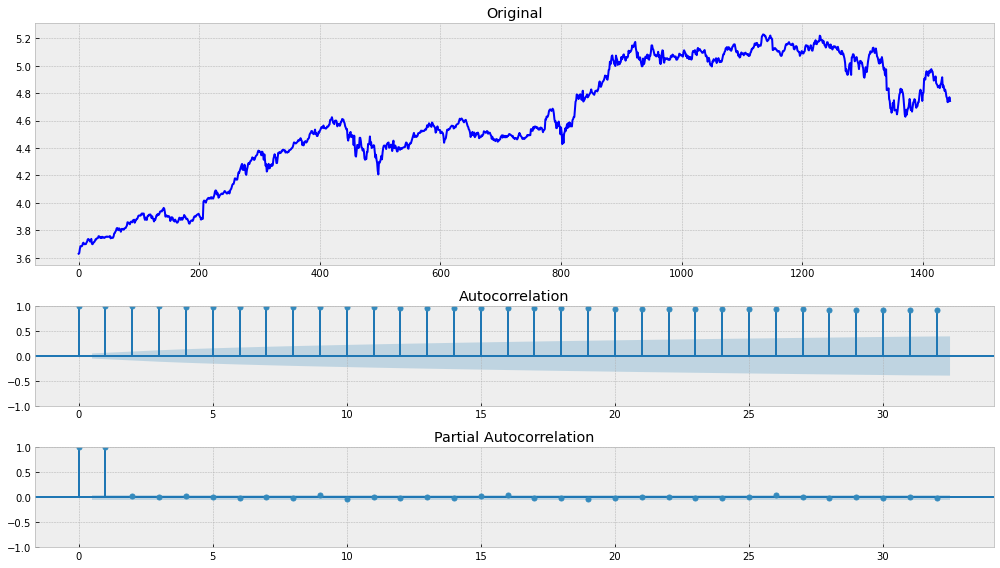

In [16]:
tsplot(series)

Ряд нестационарен. Используем дифференцирование:

In [17]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.286652e+01
p-value                        4.981810e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.436000e+03
Critical Value (1%)           -3.434912e+00
Critical Value (5%)           -2.863555e+00
Critical Value (10%)          -2.567843e+00
dtype: float64


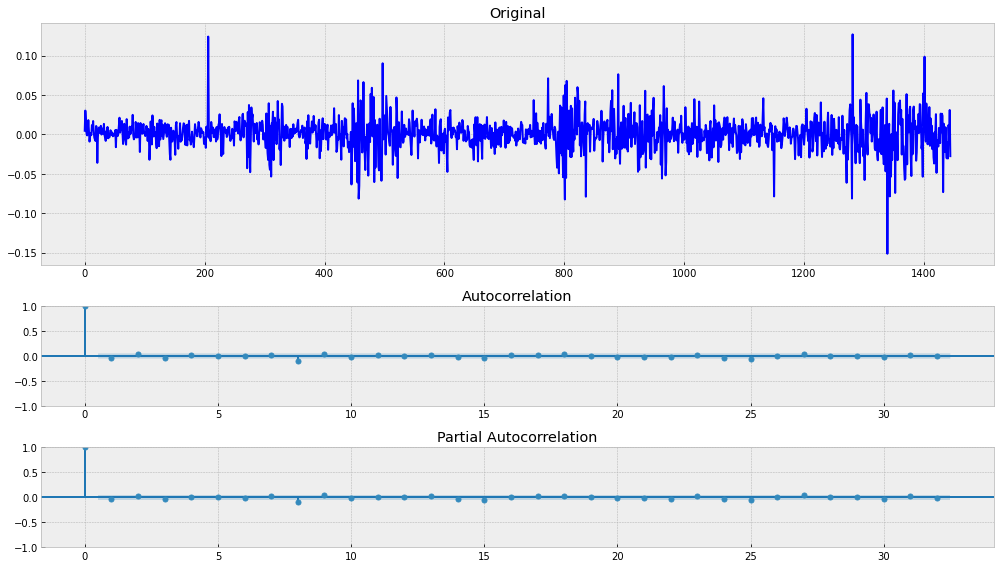

In [18]:
tsplot(series)

Теперь ряд стационарен.

In [19]:
series = df2['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.628340
p-value                           0.468360
#Lags Used                        9.000000
Number of Observations Used    1436.000000
Critical Value (1%)              -3.434912
Critical Value (5%)              -2.863555
Critical Value (10%)             -2.567843
dtype: float64


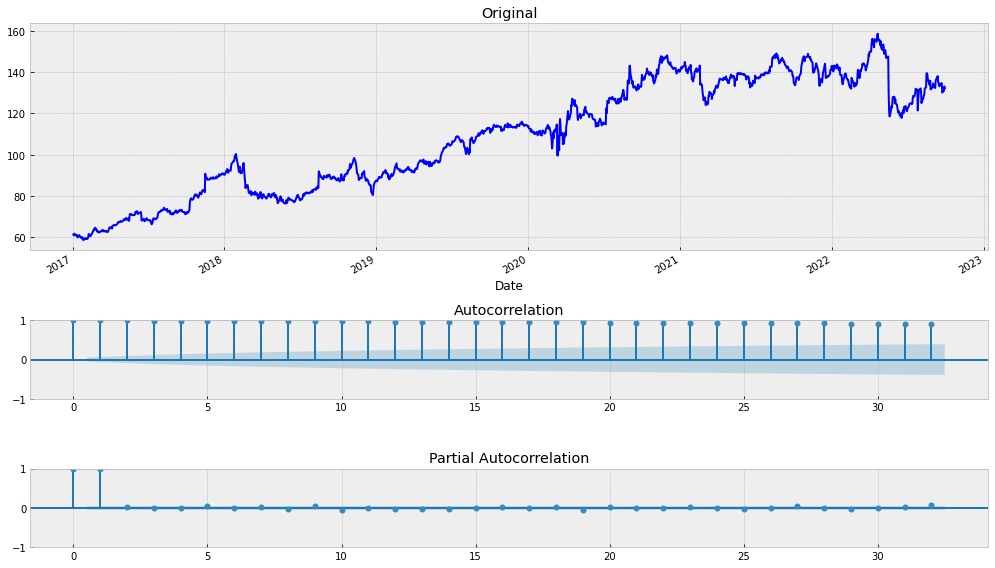

In [20]:
tsplot(series)

p-value = 0.240154 Р>0.05, значит нельзя отвергнуть нулевую гипотезу. Тест Дика-Фуллера и графики коррелограмм показывают, что ряд НЕстационарен.

Уберем изменение дисперсии пр помощи преобразования Бокса-Кокса:


In [21]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -1.935639
p-value                           0.315485
#Lags Used                        9.000000
Number of Observations Used    1436.000000
Critical Value (1%)              -3.434912
Critical Value (5%)              -2.863555
Critical Value (10%)             -2.567843
dtype: float64


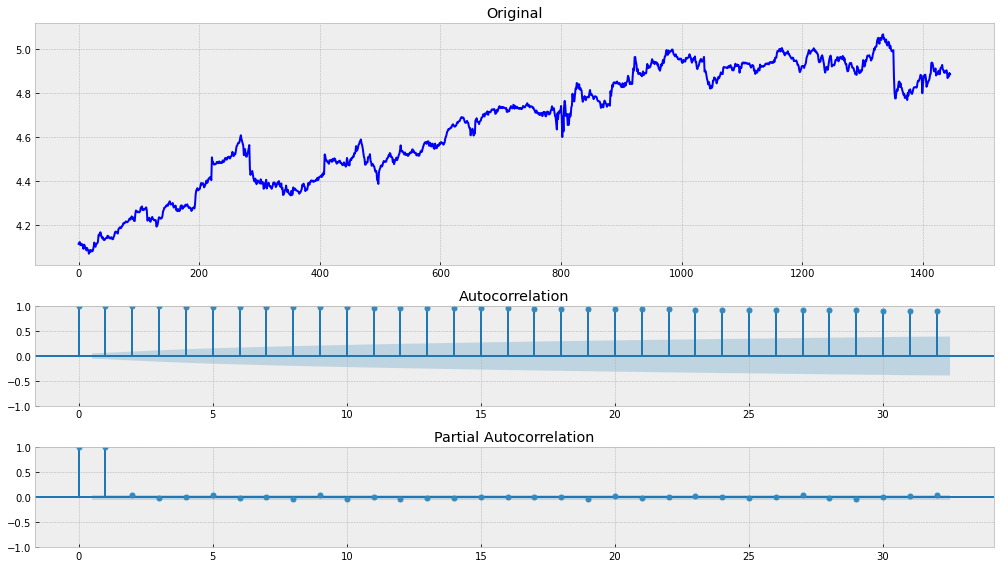

In [22]:
tsplot(series)

Ряд нестационарен. Используем дифференцирование:

In [23]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.307758e+01
p-value                        1.900038e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.436000e+03
Critical Value (1%)           -3.434912e+00
Critical Value (5%)           -2.863555e+00
Critical Value (10%)          -2.567843e+00
dtype: float64


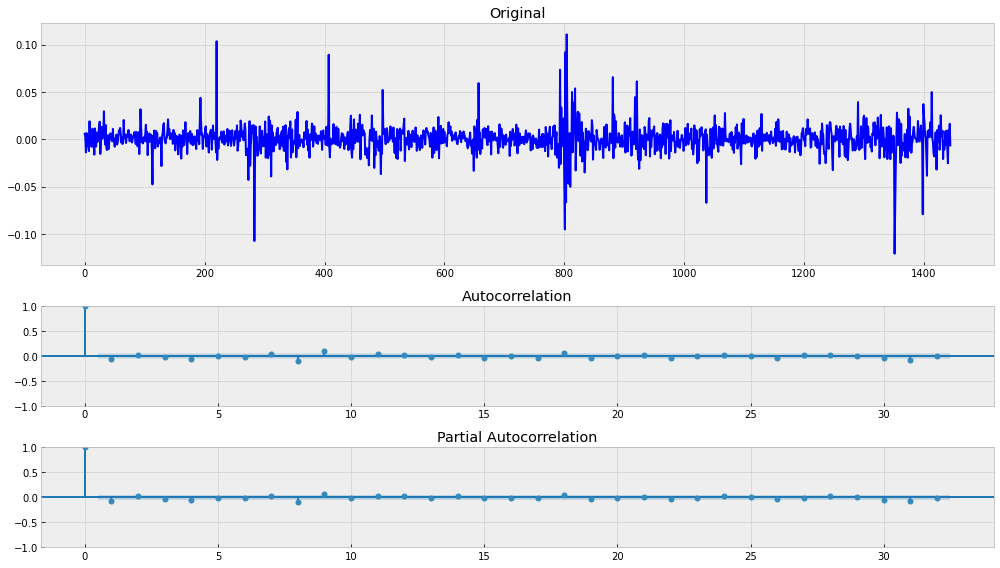

In [24]:
tsplot(series)

Теперь ряд стационарен.